In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [2]:
# read data
df = pd.read_csv("data/npf_train.csv")

In [3]:
df.head()

,id,date,class4,partlybad,CO2168.mean,CO2168.std,CO2336.mean,CO2336.std,CO242.mean,CO242.std,...,T672.mean,T672.std,T84.mean,T84.std,UV_A.mean,UV_A.std,UV_B.mean,UV_B.std,CS.mean,CS.std
0,1,2000-02-23,nonevent,False,380.528120,0.802001,380.371466,0.889550,381.816207,1.292593,...,-10.730843,1.381815,-10.282754,1.870056,8.356761,4.534937,0.178084,0.123402,0.002546,0.000686
1,2,2000-03-25,Ib,False,373.128684,1.096617,372.980000,1.047750,373.701830,1.259198,...,-2.095641,1.695622,-1.095864,2.090111,12.906779,7.022300,0.333523,0.239981,0.000662,0.000210
2,3,2000-04-06,Ib,False,372.363293,0.626329,372.245689,0.615803,372.847246,0.647279,...,0.991521,1.914186,1.846503,1.954748,14.286261,9.572444,0.418313,0.344386,0.000541,0.000072
3,4,2000-04-11,nonevent,False,381.437442,7.281159,381.380405,7.236002,381.926532,7.294374,...,1.753414,0.340565,2.524931,0.414255,4.945162,3.405652,0.224159,0.192014,0.003710,0.001209
4,5,2000-04-23,II,False,375.426310,3.264246,375.436524,3.110886,375.740215,3.274924,...,10.940107,2.179821,11.441893,3.048699,13.087014,9.771415,0.525591,0.476821,0.003680,0.002160


In [6]:
# delete some usuless columns
del df["date"]
del df["id"]
del df["partlybad"]
df.head()

,class4,CO2168.mean,CO2168.std,CO2336.mean,CO2336.std,CO242.mean,CO242.std,CO2504.mean,CO2504.std,Glob.mean,...,T672.mean,T672.std,T84.mean,T84.std,UV_A.mean,UV_A.std,UV_B.mean,UV_B.std,CS.mean,CS.std
0,nonevent,380.528120,0.802001,380.371466,0.889550,381.816207,1.292593,380.296466,0.968884,236.605353,...,-10.730843,1.381815,-10.282754,1.870056,8.356761,4.534937,0.178084,0.123402,0.002546,0.000686
1,Ib,373.128684,1.096617,372.980000,1.047750,373.701830,1.259198,372.910000,1.004164,252.480327,...,-2.095641,1.695622,-1.095864,2.090111,12.906779,7.022300,0.333523,0.239981,0.000662,0.000210
2,Ib,372.363293,0.626329,372.245689,0.615803,372.847246,0.647279,372.193952,0.596289,269.981547,...,0.991521,1.914186,1.846503,1.954748,14.286261,9.572444,0.418313,0.344386,0.000541,0.000072
3,nonevent,381.437442,7.281159,381.380405,7.236002,381.926532,7.294374,381.381156,7.208287,68.364653,...,1.753414,0.340565,2.524931,0.414255,4.945162,3.405652,0.224159,0.192014,0.003710,0.001209
4,II,375.426310,3.264246,375.436524,3.110886,375.740215,3.274924,375.337059,2.903780,242.192619,...,10.940107,2.179821,11.441893,3.048699,13.087014,9.771415,0.525591,0.476821,0.003680,0.002160


In [4]:
df['class4'].describe()

count          430
unique           4
top       nonevent
freq           215
Name: class4, dtype: object

In [5]:
df.class4.unique()

array(['nonevent', 'Ib', 'II', 'Ia'], dtype=object)

In [187]:
# select X and y variables

X = df.loc[:, df.columns != 'class4']
y = df['class4']
y = y.replace(['nonevent', 'Ia', 'Ib', 'II'],[0, 1, 2, 3])

# Feature selection

## By hand

In [188]:
def hand(X):
    # indexes to be deleted
    delidx=[]
    # loop column names
    for i,col in enumerate(X.columns):
        # Drop all .std - columns 
        if col[-4:]==".std":
            delidx.append(i)

        # Drop different altitude columns
        if col[:3]=="CO2" and col!="CO2168.mean":
            delidx.append(i)
        if col[:3]=="H20" and col != "H20168.mean":
            delidx.append(i)        
        if col[:2] == "NO" and col != "NO168.mean" and col[:3] != "NOx":
            delidx.append(i)        
        if col[:3] == "NOx" and col != "NOx168.mean":
            delidx.append(i)
        if col[:2] == "O3" and col != "O3168.mean":
            delidx.append(i)
        if col[:6] == "RHIRGA" and col != "RHIRHGA168.mean":
            delidx.append(i)
        if col[:1] == "T" and col != "T168.mean":
            delidx.append(i)
    X = X.drop(X.columns[delidx], axis=1)

    assert(len(X.columns) == 23)
    
    return X

## Recursive feature elimination

In [189]:
from sklearn.feature_selection import RFECV

def rfe(X):
    # define a model
    model = RandomForestClassifier()
    # 20cross validation, eliminate one feature per iteration
    selector = RFECV(model, step=1, cv=20) 
    # Fit to the data
    selector = selector.fit(X, y)
    # Apply dimension reduction to X
    return selector.transform(X)

## PCA

In [190]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def pca(X):
    # standarsize the data - PCA is affected by scale
    scaler = StandardScaler()
    # fit on training only
    scaler.fit(X)
    X = scaler.transform(X)

    # Feature selection using PCA
    pca = PCA(n_components=23, svd_solver='auto', tol=0.0, iterated_power='auto', random_state=None)
    # fit only on training data
    pca.fit(X)
    # Apply dimensionality reduction to X
    X = pca.transform(X)
    #print("Number of features: {}".format(len(pca.components_)))
    #print('Variance ratio: \n', pca.explained_variance_ratio_)
    return X

# Model selection

In [195]:
# KFold cross-validation
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier

def modeling(model, X):
    cv = KFold(n_splits=10, shuffle=True)
    model = model

    # evaluate model
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    # report performance
    print('Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

In [241]:
name = ["hand", "pca", "rfe"]
selection = [hand(X), pca(X), rfe(X)]

for i in range(len(name)):
    print('\n')
    print("feature selection: {}".format(name[i]))
    x = selection[i]
    modeling(LogisticRegression(),x)
    modeling(SVC(),x)
    modeling(RandomForestClassifier(n_estimators = 200, criterion = 'entropy', min_samples_leaf = 2),x)
    modeling(ExtraTreesClassifier(),x)
    modeling(DecisionTreeClassifier(),x)




feature selection: hand
Accuracy: 0.637 (0.090)
Accuracy: 0.563 (0.069)
Accuracy: 0.674 (0.083)
Accuracy: 0.642 (0.092)
Accuracy: 0.614 (0.073)


feature selection: pca
Accuracy: 0.640 (0.081)
Accuracy: 0.663 (0.073)
Accuracy: 0.660 (0.072)
Accuracy: 0.663 (0.061)
Accuracy: 0.533 (0.081)


feature selection: rfe
Accuracy: 0.644 (0.088)
Accuracy: 0.556 (0.046)
Accuracy: 0.693 (0.078)
Accuracy: 0.653 (0.064)
Accuracy: 0.635 (0.059)


## Hyperparameter optimization via random search for random forest classifier

In [226]:
from sklearn.model_selection import RandomizedSearchCV

random_search = {'criterion': ['entropy', 'gini'],
               'max_depth': list(np.linspace(10, 400, 100, dtype = int)) + [None],
               'max_features': ['auto', 'sqrt','log2', None],
               'min_samples_leaf': [2, 4, 6, 8, 12, 14],
               'min_samples_split': [2, 5, 7, 10, 14, 17],
               'n_estimators': list(np.linspace(2, 400, 100, dtype = int))}

clf = RandomForestClassifier()
model = RandomizedSearchCV(estimator = clf, param_distributions = random_search, n_iter = 80, 
                               cv = 4, verbose= 5, random_state= 101, n_jobs = -1)
model.fit(hand(X), y)

Fitting 4 folds for each of 80 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   46.3s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed:  1.5min finished


RandomizedSearchCV(cv=4, estimator=RandomForestClassifier(), n_iter=80,
                   n_jobs=-1,
                   param_distributions={'criterion': ['entropy', 'gini'],
                                        'max_depth': [10, 13, 17, 21, 25, 29,
                                                      33, 37, 41, 45, 49, 53,
                                                      57, 61, 65, 69, 73, 76,
                                                      80, 84, 88, 92, 96, 100,
                                                      104, 108, 112, 116, 120,
                                                      124, ...],
                                        'max_features': ['auto', 'sqrt', 'log2',
                                                         None],
                                        'min_samples_leaf': [2, 4, 6, 8, 12,
                                                             14],
                                        'min_samples_split': [2, 5, 7, 10, 14,


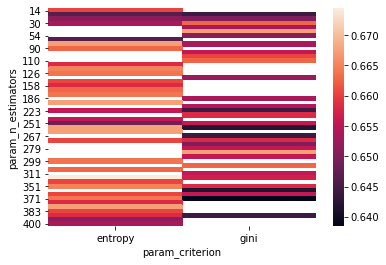

In [227]:
# accuracy heatmap

table = pd.pivot_table(pd.DataFrame(model.cv_results_),
    values='mean_test_score', index='param_n_estimators', 
                       columns='param_criterion')
     
sns.heatmap(table)

In [228]:
# let's look at a couple of the best ones

res = pd.DataFrame(model.cv_results_)
res.loc[res['rank_test_score']<=5]
# n_estimators = 200, criterion = entropy, min_samples_leaf = 2  ??

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_criterion,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
23,2.160290,0.022814,0.042678,0.003274,255,5,12,None,92,entropy,"{'n_estimators': 255, 'min_samples_split': 5, ...",0.703704,0.657407,0.682243,0.644860,0.672053,0.022691,3
24,1.469182,0.030026,0.057010,0.001495,335,2,2,log2,246,entropy,"{'n_estimators': 335, 'min_samples_split': 2, ...",0.675926,0.685185,0.682243,0.654206,0.674390,0.012124,1
26,1.246888,0.005165,0.051703,0.001688,299,7,2,sqrt,364,entropy,"{'n_estimators': 299, 'min_samples_split': 7, ...",0.675926,0.694444,0.682243,0.635514,0.672032,0.022109,4
42,1.125197,0.070919,0.049124,0.001668,291,17,12,auto,392,gini,"{'n_estimators': 291, 'min_samples_split': 17,...",0.685185,0.648148,0.682243,0.663551,0.669782,0.014995,5
55,0.733808,0.006233,0.030500,0.000881,178,10,2,log2,96,entropy,"{'n_estimators': 178, 'min_samples_split': 10,...",0.685185,0.657407,0.691589,0.654206,0.672097,0.016486,2
